In [1]:
%load_ext autoreload
%autoreload 2

# Unbiased ECMWF

Here we propose a small model which is a debiased ECMWF forecast according to the data we have.
The plan is
* Compute the bias between the ECMWF model and the observations
* Make a debiased model
* Turn this model into a probabilistic forecast
For this notebook we want to do it on precipitation and temperature, for weeks 1-2, 3-4, and 5-6.

In [2]:
import dask
import dask.array as da
import dask.distributed
import datetime
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import pathlib
import scipy.stats
import typing
import xarray as xr
import xskillscore as xs

In [3]:
from crims2s.dask import create_dask_cluster
from crims2s.util import fix_dataset_dims

In [46]:
INPUT_TRAIN = '***BASEDIR***training-input/0.3.0/netcdf'
OBSERVATIONS = '***BASEDIR***/processed/training-output-reference/'
BENCHNMARK = '***BASEDIR***training-output-benchmark/'

## Boost dask cluster

In [5]:
cluster = create_dask_cluster()
cluster.scale(jobs=2)

***REMOVED***/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43481 instead
  warnings.warn(


In [6]:
client = dask.distributed.Client(cluster)

In [7]:
client

Client Scheduler: tcp://10.20.40.91:44816 Dashboard: http://10.20.40.91:43481/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## Generic Functions

In [53]:
def extract_train_validation_from_lead_time(xr_data) -> typing.Tuple:
    xr_data_sub_train = xr_data.sel(forecast_year=slice(None, 2018))
    xr_data_sub_val = xr_data.sel(forecast_year=slice(2019, None))
    
    return xr_data_sub_train, xr_data_sub_val

In [9]:
def compute_and_correct_bias(data_center_train, data_center_val, obs_train):
    
    bias = (obs_train - data_center_train).mean(dim=['lead_time', 'forecast_year'])
    corrected_bias = data_center_val + bias
    
    return bias, corrected_bias

In [124]:
def add_biweekly_dim(dataset):
    weeklys = []
    for s in [slice('0D', '13D'), slice('14D', '27D'), slice('28D', '41D')]:
        weekly_forecast = dataset.sel(lead_time=s)

        first_lead = pd.to_timedelta(weekly_forecast.lead_time[0].item())

        weekly_forecast = weekly_forecast.expand_dims(dim='biweekly_forecast').assign_coords(biweekly_forecast=[first_lead])
        weekly_forecast = weekly_forecast.assign_coords(lead_time=(weekly_forecast.lead_time - first_lead))
        weeklys.append(weekly_forecast)
        
    return xr.concat(weeklys, dim='biweekly_forecast').transpose('forecast_year', 'forecast_dayofyear', 'biweekly_forecast', ...)

## Read data

### ECMWF Temperature

In [125]:
CENTER = 'ecmwf'
FIELD = 't2m'

In [126]:
input_path = pathlib.Path(INPUT_TRAIN)

In [127]:
input_files_t2m = sorted([f for f in input_path.iterdir() if CENTER in f.stem and FIELD in f.stem])

In [128]:
input_files_t2m[:10]

[PosixPath('***BASEDIR***training-input/0.3.0/netcdf/ecmwf-hindcast-t2m-20200102.nc'),
 PosixPath('***BASEDIR***training-input/0.3.0/netcdf/ecmwf-hindcast-t2m-20200109.nc'),
 PosixPath('***BASEDIR***training-input/0.3.0/netcdf/ecmwf-hindcast-t2m-20200116.nc'),
 PosixPath('***BASEDIR***training-input/0.3.0/netcdf/ecmwf-hindcast-t2m-20200123.nc'),
 PosixPath('***BASEDIR***training-input/0.3.0/netcdf/ecmwf-hindcast-t2m-20200130.nc'),
 PosixPath('***BASEDIR***training-input/0.3.0/netcdf/ecmwf-hindcast-t2m-20200206.nc'),
 PosixPath('***BASEDIR***training-input/0.3.0/netcdf/ecmwf-hindcast-t2m-20200213.nc'),
 PosixPath('***BASEDIR***training-input/0.3.0/netcdf/ecmwf-hindcast-t2m-20200220.nc'),
 PosixPath('***BASEDIR***training-input/0.3.0/netcdf/ecmwf-hindcast-t2m-20200227.nc'),
 PosixPath('***BASEDIR***training-input/0.3.0/netcdf/ecmwf-hindcast-t2m-20200305.nc')]

In [138]:
ecmwf_t2m_raw = xr.open_mfdataset(input_files_t2m, preprocess=fix_dataset_dims)
ecmwf_t2m_raw = ecmwf_t2m_raw.assign_coords(lead_time=ecmwf_t2m_raw.lead_time - ecmwf_t2m_raw.lead_time[0])
# Fix the lead times by starting them at 0. To be validated with the organizers.

In [139]:
ecmwf_t2m = add_biweekly_dim(ecmwf_t2m_raw)

In [140]:
ecmwf_t2m

,Array,Chunk
Bytes,347.81 kiB,2.19 kiB
Shape,"(20, 53, 3, 14)","(20, 1, 1, 14)"
Count,846 Tasks,159 Chunks
Type,datetime64[ns],numpy.ndarray
,Array,Chunk
Bytes,52.98 GiB,341.20 MiB
Shape,"(20, 53, 3, 14, 11, 121, 240)","(20, 1, 1, 14, 11, 121, 240)"
Count,901 Tasks,159 Chunks
Type,float32,numpy.ndarray


### Observations

In [141]:
obs_path = pathlib.Path(OBSERVATIONS)
obs_files = [f for f in obs_path.iterdir() if 't2m' in f.stem]

In [142]:
obs_files[:4]

[PosixPath('***BASEDIR***/processed/training-output-reference/obs_t2m_forecast_shape_2009.nc'),
 PosixPath('***BASEDIR***/processed/training-output-reference/obs_t2m_forecast_shape_2008.nc'),
 PosixPath('***BASEDIR***/processed/training-output-reference/obs_t2m_forecast_shape_2018.nc'),
 PosixPath('***BASEDIR***/processed/training-output-reference/obs_t2m_forecast_shape_2019.nc')]

In [143]:
obs_t2m_raw = xr.open_mfdataset(obs_files)
obs_t2m_raw = obs_t2m_raw.assign_coords(lead_time=obs_t2m_raw.lead_time - obs_t2m_raw.lead_time[0])

In [144]:
obs_t2m = add_biweekly_dim(obs_t2m_raw)

In [145]:
obs_t2m

<xarray.Dataset>
Dimensions:             (biweekly_forecast: 3, forecast_dayofyear: 53, forecast_year: 20, latitude: 121, lead_time: 14, longitude: 240)
Coordinates:
    valid_time          (forecast_year, forecast_dayofyear, biweekly_forecast, lead_time) datetime64[ns] dask.array<chunksize=(1, 53, 1, 14), meta=np.ndarray>
  * latitude            (latitude) float64 90.0 88.5 87.0 ... -87.0 -88.5 -90.0
  * longitude           (longitude) float64 0.0 1.5 3.0 ... 355.5 357.0 358.5
    forecast_time       (forecast_year, forecast_dayofyear) datetime64[ns] dask.array<chunksize=(1, 53), meta=np.ndarray>
  * lead_time           (lead_time) timedelta64[ns] 0 days 1 days ... 13 days
  * forecast_dayofyear  (forecast_dayofyear) int64 2 9 16 23 ... 345 352 359 366
  * forecast_year       (forecast_year) int64 2000 2001 2002 ... 2017 2018 2019
  * biweekly_forecast   (biweekly_forecast) timedelta64[ns] 0 days ... 28 days
Data variables:
    t2m                 (forecast_year, forecast_dayofyear, biweekly_forecast, lead_time, latitude, longitude) float32 dask.array<chunksize=(1, 53, 1, 14, 121, 240), meta=np.ndarray>
Attributes:
    source_dataset_name:  temperature daily from NOAA NCEP CPC: Climate Predi...
    source_hosting:       IRIDL
    source_url:           http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/...
    created_by_software:  climetlab-s2s-ai-challenge
    created_by_script:    tools/observations/makefile
    function:             climetlab_s2s_ai_challenge.extra.forecast_like_obse...

In [146]:
ecmwf_t2m_train, ecmwf_t2m_val = extract_train_validation_from_lead_time(ecmwf_t2m)

In [147]:
obs_t2m_train, obs_t2m_val = extract_train_validation_from_lead_time(obs_t2m)

In [148]:
ecmwf_t2m_train

,Array,Chunk
Bytes,330.42 kiB,2.08 kiB
Shape,"(19, 53, 3, 14)","(19, 1, 1, 14)"
Count,1005 Tasks,159 Chunks
Type,datetime64[ns],numpy.ndarray
,Array,Chunk
Bytes,50.33 GiB,324.14 MiB
Shape,"(19, 53, 3, 14, 11, 121, 240)","(19, 1, 1, 14, 11, 121, 240)"
Count,1060 Tasks,159 Chunks
Type,float32,numpy.ndarray


In [149]:
obs_t2m_train

<xarray.Dataset>
Dimensions:             (biweekly_forecast: 3, forecast_dayofyear: 53, forecast_year: 19, latitude: 121, lead_time: 14, longitude: 240)
Coordinates:
    valid_time          (forecast_year, forecast_dayofyear, biweekly_forecast, lead_time) datetime64[ns] dask.array<chunksize=(1, 53, 1, 14), meta=np.ndarray>
  * latitude            (latitude) float64 90.0 88.5 87.0 ... -87.0 -88.5 -90.0
  * longitude           (longitude) float64 0.0 1.5 3.0 ... 355.5 357.0 358.5
    forecast_time       (forecast_year, forecast_dayofyear) datetime64[ns] dask.array<chunksize=(1, 53), meta=np.ndarray>
  * lead_time           (lead_time) timedelta64[ns] 0 days 1 days ... 13 days
  * forecast_dayofyear  (forecast_dayofyear) int64 2 9 16 23 ... 345 352 359 366
  * forecast_year       (forecast_year) int64 2000 2001 2002 ... 2016 2017 2018
  * biweekly_forecast   (biweekly_forecast) timedelta64[ns] 0 days ... 28 days
Data variables:
    t2m                 (forecast_year, forecast_dayofyear, biweekly_forecast, lead_time, latitude, longitude) float32 dask.array<chunksize=(1, 53, 1, 14, 121, 240), meta=np.ndarray>
Attributes:
    source_dataset_name:  temperature daily from NOAA NCEP CPC: Climate Predi...
    source_hosting:       IRIDL
    source_url:           http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/...
    created_by_software:  climetlab-s2s-ai-challenge
    created_by_script:    tools/observations/makefile
    function:             climetlab_s2s_ai_challenge.extra.forecast_like_obse...

## Debiasing

### Compute bias using training data

In [150]:
ecmwf_t2m_bias = (obs_t2m_train - ecmwf_t2m_train).mean(dim=['lead_time', 'forecast_year'])

***REMOVED***/lib/python3.8/site-packages/dask/array/core.py:4346: PerformanceWarning: Increasing number of chunks by factor of 19
  result = blockwise(


In [151]:
ecmwf_t2m_bias

,Array,Chunk
Bytes,193.75 MiB,1.22 MiB
Shape,"(53, 3, 121, 240, 11)","(1, 1, 121, 240, 11)"
Count,23155 Tasks,159 Chunks
Type,float32,numpy.ndarray


### Bias correct ECMWF

In [152]:
ecmwf_t2m_val_corrected = ecmwf_t2m_val + ecmwf_bias

In [153]:
ecmwf_t2m_val_corrected

,Array,Chunk
Bytes,17.39 kiB,112 B
Shape,"(1, 53, 3, 14)","(1, 1, 1, 14)"
Count,1005 Tasks,159 Chunks
Type,datetime64[ns],numpy.ndarray
,Array,Chunk
Bytes,2.65 GiB,17.06 MiB
Shape,"(1, 53, 3, 14, 11, 121, 240)","(1, 1, 1, 14, 11, 121, 240)"
Count,23731 Tasks,159 Chunks
Type,float32,numpy.ndarray


In [154]:
ecmwf_t2m_val_corrected_comp = ecmwf_t2m_val_corrected.compute()

## Turn into probabilistic forecast

### Get thresholds from train observations

In [155]:
obs_t2m_train_thresholds = obs_t2m_train.chunk({'forecast_year': -1}).quantile([0.33, 0.67], dim=['lead_time', 'forecast_year'])

In [156]:
obs_t2m_train_thresholds

<xarray.Dataset>
Dimensions:             (biweekly_forecast: 3, forecast_dayofyear: 53, latitude: 121, longitude: 240, quantile: 2)
Coordinates:
  * latitude            (latitude) float64 90.0 88.5 87.0 ... -87.0 -88.5 -90.0
  * longitude           (longitude) float64 0.0 1.5 3.0 ... 355.5 357.0 358.5
  * forecast_dayofyear  (forecast_dayofyear) int64 2 9 16 23 ... 345 352 359 366
  * biweekly_forecast   (biweekly_forecast) timedelta64[ns] 0 days ... 28 days
  * quantile            (quantile) float64 0.33 0.67
Data variables:
    t2m                 (quantile, forecast_dayofyear, biweekly_forecast, latitude, longitude) float64 dask.array<chunksize=(2, 53, 1, 121, 240), meta=np.ndarray>

In [157]:
obs_t2m_train_thresholds_comp = obs_t2m_train_thresholds.compute()

### Compute p of thresholds according to the model

There are two ways to do this. 
We can either count the amount of members that are whithin each category.
Or compute a distribution of all the members of the model, and then compute the value of the CDF for each threshold.

Here we do it using the distribution method.

#### Compute a distribution of the members of the model

In [158]:
ecmwf_t2m_val_corrected_mean = ecmwf_t2m_val_corrected_comp.mean(dim=['realization', 'lead_time'])
ecmwf_t2m_val_corrected_std = ecmwf_t2m_val_corrected_comp.std(dim=['realization', 'lead_time'])

***REMOVED***/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


#### Compute the value of the CDF for each threshold

In [159]:
ecmwf_t2m_val_corrected_mean

<xarray.Dataset>
Dimensions:             (biweekly_forecast: 3, forecast_dayofyear: 53, forecast_year: 1, latitude: 121, longitude: 240)
Coordinates:
    forecast_time       (forecast_year, forecast_dayofyear) datetime64[ns] 20...
  * latitude            (latitude) float64 90.0 88.5 87.0 ... -87.0 -88.5 -90.0
  * longitude           (longitude) float64 0.0 1.5 3.0 ... 355.5 357.0 358.5
  * forecast_dayofyear  (forecast_dayofyear) int64 2 9 16 23 ... 345 352 359 366
  * forecast_year       (forecast_year) int64 2019
  * biweekly_forecast   (biweekly_forecast) timedelta64[ns] 0 days ... 28 days
Data variables:
    t2m                 (forecast_year, forecast_dayofyear, biweekly_forecast, latitude, longitude) float32 ...

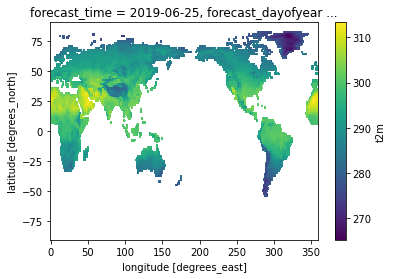

In [111]:
ecmwf_t2m_val_corrected_mean.isel(biweekly_forecast=1, forecast_dayofyear=25).t2m.plot()

In [114]:
obs_t2m_train_thresholds_comp

<xarray.Dataset>
Dimensions:             (biweekly_forecast: 3, forecast_dayofyear: 53, latitude: 121, longitude: 240, quantile: 2)
Coordinates:
  * latitude            (latitude) float64 90.0 88.5 87.0 ... -87.0 -88.5 -90.0
  * longitude           (longitude) float64 0.0 1.5 3.0 ... 355.5 357.0 358.5
  * forecast_dayofyear  (forecast_dayofyear) int64 2 9 16 23 ... 345 352 359 366
  * biweekly_forecast   (biweekly_forecast) timedelta64[ns] 0 days ... 28 days
  * quantile            (quantile) float64 0.33 0.67
Data variables:
    t2m                 (quantile, biweekly_forecast, forecast_dayofyear, latitude, longitude) float64 ...

In [192]:
def make_probabilistic(forecast, thresholds):   
    loc = forecast.mean(dim=['realization', 'lead_time']).compute().t2m
    scale = forecast.std(dim=['realization', 'lead_time']).compute().t2m
    
    cdfs = xr.apply_ufunc(scipy.stats.norm.cdf, thresholds.t2m, dask='allowed', kwargs={'loc': loc, 'scale': scale})
    
    below = cdfs.isel(quantile=0).drop_vars('quantile')
    normal = (cdfs.isel(quantile=1) - cdfs.isel(quantile=0))
    above = xr.ones_like(normal) - cdfs.isel(quantile=1).drop_vars('quantile')
    
    return xr.Dataset({'t2m': xr.concat([below, normal, above], 'category').assign_coords(category=['below normal', 'near normal', 'above normal'])})

In [193]:
val_probabilistic_forecast = make_probabilistic(ecmwf_t2m_val_corrected_comp, obs_t2m_train_thresholds_comp)

***REMOVED***/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [201]:
val_probabilistic_forecast = val_probabilistic_forecast.expand_dims('forecast_year').assign_coords(forecast_year=ecmwf_t2m_val_corrected_comp.forecast_year)

ValueError: Dimension forecast_year already exists.

In [202]:
#val_probabilistic_forecast = val_probabilistic_forecast.assign_coords(valid_time=ecmwf_t2m_val_corrected_comp.valid_time)

In [211]:
val_probabilistic_forecast.biweekly_forecast.data

array([               0, 1209600000000000, 2419200000000000],
      dtype='timedelta64[ns]')

In [213]:
val_probabilistic_forecast = val_probabilistic_forecast.drop('valid_time').drop('lead_time').rename_dims({'biweekly_forecast': 'lead_time'}).assign_coords(lead_time=val_probabilistic_forecast.biweekly_forecast.data)

In [214]:
val_probabilistic_forecast

<xarray.Dataset>
Dimensions:             (category: 3, forecast_dayofyear: 53, forecast_year: 1, latitude: 121, lead_time: 3, longitude: 240)
Coordinates:
  * latitude            (latitude) float64 90.0 88.5 87.0 ... -87.0 -88.5 -90.0
  * longitude           (longitude) float64 0.0 1.5 3.0 ... 355.5 357.0 358.5
  * forecast_dayofyear  (forecast_dayofyear) int64 2 9 16 23 ... 345 352 359 366
    biweekly_forecast   (lead_time) timedelta64[ns] 0 days 14 days 28 days
  * category            (category) <U12 'below normal' ... 'above normal'
  * forecast_year       (forecast_year) int64 2019
    forecast_time       (forecast_year, forecast_dayofyear) datetime64[ns] 20...
  * lead_time           (lead_time) timedelta64[ns] 0 days 14 days 28 days
Data variables:
    t2m                 (forecast_year, category, forecast_dayofyear, lead_time, latitude, longitude) float64 ...

In [215]:
val_probabilistic_forecast.to_netcdf('***BASEDIR***/test_t2m_forecast.nc')

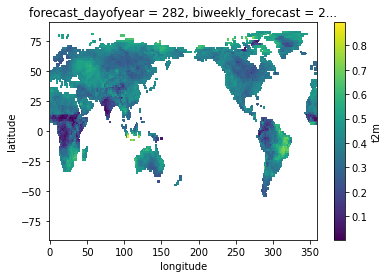

In [166]:
val_probabilistic_forecast.isel(category=2, forecast_dayofyear=40, biweekly_forecast=2).plot()

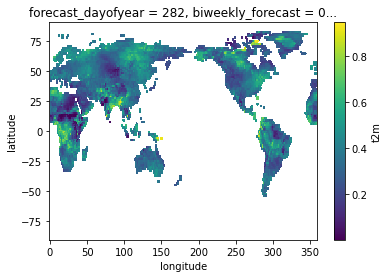

In [167]:
val_probabilistic_forecast.isel(category=1, forecast_dayofyear=40, biweekly_forecast=0).plot()

### Sanity check

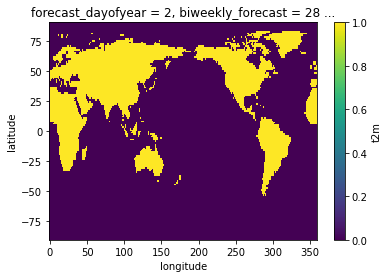

In [171]:
val_probabilistic_forecast.sum(dim='category').isel(forecast_dayofyear=0, biweekly_forecast=2).plot()

## Make submission file out of it

In [186]:
val_probabilistic_forecast_unfixed = xr.Dataset({'t2m': val_probabilistic_forecast.stack(forecast_time=['forecast_year', 'forecast_dayofyear'])})

In [187]:
val_probabilistic_forecast_unfixed.assign_coords()

<xarray.Dataset>
Dimensions:             (biweekly_forecast: 3, category: 3, forecast_time: 53, latitude: 121, longitude: 240)
Coordinates:
  * latitude            (latitude) float64 90.0 88.5 87.0 ... -87.0 -88.5 -90.0
  * longitude           (longitude) float64 0.0 1.5 3.0 ... 355.5 357.0 358.5
  * biweekly_forecast   (biweekly_forecast) timedelta64[ns] 0 days ... 28 days
  * category            (category) <U12 'below normal' ... 'above normal'
  * forecast_time       (forecast_time) MultiIndex
  - forecast_year       (forecast_time) int64 2019 2019 2019 ... 2019 2019 2019
  - forecast_dayofyear  (forecast_time) int64 2 9 16 23 30 ... 345 352 359 366
Data variables:
    t2m                 (category, biweekly_forecast, latitude, longitude, forecast_time) float64 ...

In [ ]:
forecast_times = []
for 